# About
Named Entity Recognition using Bidirectional LSTM.
[Reference Link](https://createmomo.github.io/2017/09/12/CRF_Layer_on_the_Top_of_BiLSTM_1/) 

In [1]:
!nvidia-smi

Sat Apr  3 14:37:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
#importing modules
import pandas as pd
import os
import random
import tensorflow.keras as keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
! pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9rpqes7b
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9rpqes7b
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=28b9ea8828ff3bab70d789e25fac8bbce019a61d9ab1c7b7741887fc6c9c298a
  Stored in directory: /tmp/pip-ephem-wheel-cache-3jtibfvl/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [51]:
#changing the path
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/NER_Dataset')

In [52]:
#!unzip NER.zip

In [53]:
#reading the dataset
dataset = pd.read_csv("ner_dataset.csv", sep=",", encoding="latin1").fillna(method='ffill')
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


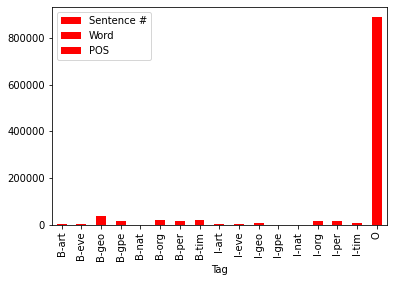

In [54]:
#let's plot 
dataset.groupby('Tag').count().plot.bar(color='red')

In [55]:
#combining the sentences and their and Tag.
combiner_function = lambda sentence: [[word,tag] for word,tag in zip(sentence["Word"].values.tolist(), 
                                            sentence["Tag"].values.tolist())]

In [56]:
combined_dataset = dataset.groupby("Sentence #").apply(combiner_function).reset_index().rename(columns= {0: 'Sentence_Tag_pair'})


In [57]:
combined_dataset.head()

,Sentence #,Sentence_Tag_pair
0,Sentence: 1,"[[Thousands, O], [of, O], [demonstrators, O], ..."
1,Sentence: 10,"[[Iranian, B-gpe], [officials, O], [say, O], [..."
2,Sentence: 100,"[[Helicopter, O], [gunships, O], [Saturday, B-..."
3,Sentence: 1000,"[[They, O], [left, O], [after, O], [a, O], [te..."
4,Sentence: 10000,"[[U.N., B-geo], [relief, O], [coordinator, O],..."


In [58]:
#splitting into sentence and tags
combined_dataset['Sentence']=combined_dataset['Sentence_Tag_pair'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
combined_dataset['Tag']=combined_dataset['Sentence_Tag_pair'].apply(lambda sentence:" ".join([s[1] for s in sentence]))

In [59]:
combined_dataset.head()

,Sentence #,Sentence_Tag_pair,Sentence,Tag
0,Sentence: 1,"[[Thousands, O], [of, O], [demonstrators, O], ...",Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Sentence: 10,"[[Iranian, B-gpe], [officials, O], [say, O], [...",Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Sentence: 100,"[[Helicopter, O], [gunships, O], [Saturday, B-...",Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,Sentence: 1000,"[[They, O], [left, O], [after, O], [a, O], [te...",They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,Sentence: 10000,"[[U.N., B-geo], [relief, O], [coordinator, O],...",U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


In [60]:
#seperating white spaces to create lists
combined_dataset['sentences_list']=combined_dataset['Sentence'].apply(lambda x:x.split())
combined_dataset['tag_list']=combined_dataset['Tag'].apply(lambda x:x.split())
combined_dataset.head()

,Sentence #,Sentence_Tag_pair,Sentence,Tag,sentences_list,tag_list
0,Sentence: 1,"[[Thousands, O], [of, O], [demonstrators, O], ...",Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 10,"[[Iranian, B-gpe], [officials, O], [say, O], [...",Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[[Helicopter, O], [gunships, O], [Saturday, B-...",Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,Sentence: 1000,"[[They, O], [left, O], [after, O], [a, O], [te...",They left after a tense hour-long standoff wit...,O O O O O O O O O O O,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[[U.N., B-geo], [relief, O], [coordinator, O],...",U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."


In [61]:
#checking if each word in sentence has a tag or not. If not, dropping
combined_dataset['len_sentence']=combined_dataset['sentences_list'].apply(lambda x:len(x))
combined_dataset['len_tag']=combined_dataset['tag_list'].apply(lambda x:len(x))
combined_dataset['is_equal']=combined_dataset.apply(lambda row:1 if row['len_sentence']==row['len_tag'] else 0,axis=1)
combined_dataset['is_equal'].value_counts()

1    47955
0        4
Name: is_equal, dtype: int64

In [62]:
#dropping all those columns where the aforementioned criteria doesn't match
combined_dataset=combined_dataset[combined_dataset['is_equal']!=0]

In [63]:
combined_dataset.shape

(47955, 9)

# Tokenisation

In [64]:
max_len_sentences = max([len(s) for s in combined_dataset['sentences_list'].tolist()])
print(max_len_sentences)

104


In [65]:
max_features = 2000
# removing unneccessary punctuations while tokenizing
tokenizer = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(combined_dataset['sentences_list'].tolist())
features = tokenizer.texts_to_sequences(combined_dataset['sentences_list'].tolist())
features = pad_sequences(features,padding='post', maxlen= max_len)

In [66]:
features.shape

(47955, 104)

In [87]:
#creating labels dictionary
labels_dict = {'B-tim': 0, 'O': 1, 'I-tim': 2, 'I-org': 3, 'B-org': 4, 'B-art': 5, 'B-nat': 6, 'B-gpe': 7, 'I-nat': 8, 'B-geo': 9, 'B-eve': 10, 'I-gpe': 11, 'I-art': 12, 'I-per': 13, 'I-geo': 14, 'B-per': 15, 'I-eve': 16}
encoded_labels = [[labels_dict[word] for word in tag] for tag in combined_dataset['tag_list']]

In [88]:
#zero_padding_encoded labels too
encoded_labels = pad_sequences(maxlen= max_len_sentences, sequences= encoded_labels, padding="post",value= labels_dict["O"])

In [89]:
print(np.shape(encoded_labels))

(47955, 104)


In [90]:
encoded_labels[0]

array([1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 7, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [95]:
tags_labels = [to_categorical(i, num_classes=17) for i in encoded_labels]

In [96]:
#splitting the data to train and test 
X_train, X_val, y_train, y_val = train_test_split(features, tags_labels, test_size=0.3)

In [97]:
print("Input training features and label shape are {},{}".format(np.shape(X_train),np.shape(y_train)))
print("Input validation features and label shape are {}, {}".format(np.shape(X_val),np.shape(y_val)))

Input training features and label shape are (33568, 104),(33568, 104, 17)
Input validation features and label shape are (14387, 104), (14387, 104, 17)


In [98]:
#converting labels to numpy array 
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [112]:
input = Input(shape=(104,))
out = Embedding(input_dim=len(X_train), output_dim=300,  input_length=104)(input)  
out = Bidirectional(LSTM(units=300, return_sequences=True,recurrent_dropout=0.1))(out) 
out = TimeDistributed(Dense(17, activation="relu"))(out)  
BiLSTM = Model(input, out)
BiLSTM.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
BiLSTM.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 104)]             0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 104, 300)          10070400  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 104, 600)          1442400   
_________________________________________________________________
time_distributed_13 (TimeDis (None, 104, 17)           10217     
Total params: 11,523,017
Trainable params: 11,523,017
Non-trainable params: 0
_________________________________________________________________


In [113]:
#saving best checkpoint model
checkpoint = ModelCheckpoint('trained_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

In [114]:
bilstm_history = BiLSTM.fit(X_train, y_train, batch_size=512, epochs = 5, validation_data=(X_val,y_val), verbose=1, callbacks=callbacks)

Epoch 1/5
66/66 [==============================] - 40s 556ms/step - loss: 1.3331 - accuracy: 0.8988 - val_loss: 0.1353 - val_accuracy: 0.9679
Epoch 2/5
66/66 [==============================] - 36s 546ms/step - loss: nan - accuracy: 0.9690 - val_loss: 0.0925 - val_accuracy: 0.9741
Epoch 3/5
66/66 [==============================] - 36s 547ms/step - loss: nan - accuracy: 0.9745 - val_loss: nan - val_accuracy: 0.9772
Epoch 4/5
66/66 [==============================] - 36s 546ms/step - loss: nan - accuracy: 0.9773 - val_loss: nan - val_accuracy: 0.9783
Epoch 5/5
66/66 [==============================] - 36s 540ms/step - loss: nan - accuracy: 0.9787 - val_loss: nan - val_accuracy: 0.9800


In [115]:
bilstm_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

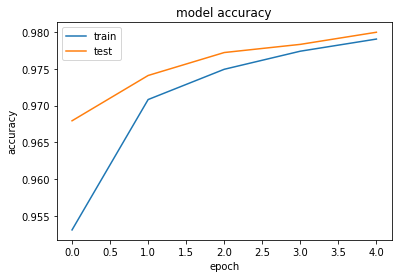

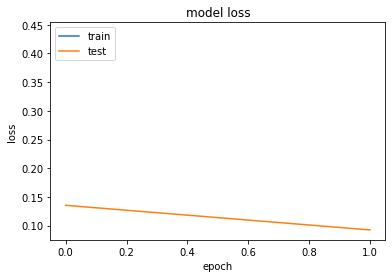

In [116]:
import matplotlib.pyplot as plt
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
#prediction
text = "This is a game of CRF hosted in the battle of fields where tycoons come around"
max_features = 2000
# removing unneccessary punctuations while tokenizing
tokenizer = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(text)
features = tokenizer.texts_to_sequences(text)
features = pad_sequences(features,padding='post', maxlen= max_len)

In [ ]:
np.argmax(BiLSTM.predict(features, batch_size=1)[0])